In [59]:
import glob
import torch
import numpy as np
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import tensorflow as tf
import torch
from tensorflow.python.summary.summary_iterator import summary_iterator



def compute_flops(grow, before_grow = 1.400e+09, after_grow = 5.590e+09, n_students=1):  ## after = 4x before 
    """
        before_grow: 1395898880 for tf, 1.400e+09 for "ours." and "ours. ens."
        
    """
    epochs = 100

    our_flops_by_epochs = np.array([before_grow * n_students] * grow + [after_grow] * (epochs - grow))
    our_flops = our_flops_by_epochs.cumsum()
    return our_flops


In [60]:
def parse_eventfiles(summary_dir): 
    step_acc_list = []
    for filename in os.listdir(summary_dir):
        sum_iter =  summary_iterator(os.path.join(summary_dir,filename))
        for summ in sum_iter:
            if summ.HasField('summary'):
                if summ.summary.value[0].tag == 'test/accuracy':
                    step_acc_list.append((summ.step,(tf.make_ndarray(summ.summary.value[0].tensor) * 100)))

                    
    return sorted(step_acc_list, key=lambda x: x[0])

In [61]:
cd /projectnb/ivc-ml/piotrt/gradmax/growneuron


/projectnb/ivc-ml/piotrt/gradmax/growneuron


In [62]:
growth_list = [7000,11000,15000,16422,19000,23000, 24570, 27000]
epoch_list = [growth//391 for growth in growth_list]
flop_list = [compute_flops(growth, before_grow=1395898880)[-1] for growth in epoch_list]
data_random = []
data_gradmax = []
data_firefly = []
random_template = 'outputs/cifar/{}_single/gm_random_cifar/summaries/'
gradmax_template = 'outputs/cifar/{}_single/gm_gradmax_cifar/summaries/'
firefly_template = 'outputs/cifar/{}_single/gm_firefly_cifar/summaries/'
random_template_2 = 'outputs/cifar/{}_single_2/gm_random_cifar/summaries/'
gradmax_template_2 = 'outputs/cifar/{}_single_2/gm_gradmax_cifar/summaries/'
firefly_template_2 = 'outputs/cifar/{}_single_2/gm_firefly_cifar/summaries/'
random_template_3 = 'outputs/cifar/{}_single_3/gm_random_cifar/summaries/'
gradmax_template_3 = 'outputs/cifar/{}_single_3/gm_gradmax_cifar/summaries/'
firefly_template_3 = 'outputs/cifar/{}_single_3/gm_firefly_cifar/summaries/'

In [63]:
for growth in growth_list:
    random = random_template.format(growth)
    gradmax = gradmax_template.format(growth)
    firefly = firefly_template.format(growth)
    
    random_2 = random_template_2.format(growth)
    gradmax_2 = gradmax_template_2.format(growth)
    firefly_2 = firefly_template_2.format(growth)
    
    random_3 = random_template_3.format(growth)
    gradmax_3 = gradmax_template_3.format(growth)
    firefly_3 = firefly_template_3.format(growth)
    
    average_random = (list(zip(*parse_eventfiles(random)))[1][-1] + list(zip(*parse_eventfiles(random_2)))[1][-1] + \
        list(zip(*parse_eventfiles(random_3)))[1][-1])/3.
    average_gradmax = (list(zip(*parse_eventfiles(gradmax)))[1][-1] + list(zip(*parse_eventfiles(gradmax_2)))[1][-1] + \
        list(zip(*parse_eventfiles(gradmax_3)))[1][-1])/3.
    average_firefly = (list(zip(*parse_eventfiles(firefly)))[1][-1] + list(zip(*parse_eventfiles(firefly_2)))[1][-1] + \
        list(zip(*parse_eventfiles(firefly_3)))[1][-1])/3.
    
    
    data_random.append(average_random)
    data_gradmax.append(average_gradmax)
    data_firefly.append(average_firefly)
    


In [64]:
epoch_list

[17, 28, 38, 42, 48, 58, 62, 69]

In [65]:
flop_list

[487700280960.0,
 441565168640.0,
 399624157440.0,
 382847752960.0,
 357683146240.0,
 315742135040.0,
 298965730560.0,
 269607022720.0]

In [66]:
data_gradmax

[78.07826002438863,
 77.9647429784139,
 77.99479166666667,
 77.89129217465718,
 77.92468070983887,
 77.90464758872986,
 78.04820934931438,
 77.88795431454976]

In [67]:
gradmax_zipped = list(zip(epoch_list, data_gradmax, flop_list))
firefly_zipped = list(zip(epoch_list, data_firefly, flop_list))
random_zipped = list(zip(epoch_list, data_random, flop_list))

In [68]:
gradmax_zipped

[(17, 78.07826002438863, 487700280960.0),
 (28, 77.9647429784139, 441565168640.0),
 (38, 77.99479166666667, 399624157440.0),
 (42, 77.89129217465718, 382847752960.0),
 (48, 77.92468070983887, 357683146240.0),
 (58, 77.90464758872986, 315742135040.0),
 (62, 78.04820934931438, 298965730560.0),
 (69, 77.88795431454976, 269607022720.0)]

In [69]:
cd /projectnb/ivc-ml/chaupham/anytime/param_share/incremental_training/

/projectnb/ivc-ml/chaupham/anytime/param_share/incremental_training


In [70]:
path = "/projectnb/ivc-ml/chaupham/anytime/param_share/incremental_training/snapshots/cifar100_ours_ens_bank_size_8_v2_grow_*"
replace_name = "cifar100_ours_ens_bank_size_8_v2_grow_"
all_paths = glob.glob(path)
# all_paths


In [71]:
store = defaultdict(list)
for path in all_paths:
    try:
        checkpoint = torch.load(path + "/checkpoint.pth.tar", map_location=torch.device('cpu'))
        grow_epoch = int(path.split("/")[-1].replace(replace_name, "").split("_")[0])
        acc = checkpoint['recorder'].epoch_accuracy[:,1][-1]
        store[grow_epoch].append(acc)
    except Exception as e:
        print("Skipped failed run.")
        print("Exception:", e)
        
for k in store:
    store[k] = np.array(store[k])
    


Skipped failed run.
Exception: [Errno 2] No such file or directory: '/projectnb/ivc-ml/chaupham/anytime/param_share/incremental_training/snapshots/cifar100_ours_ens_bank_size_8_v2_grow_68_seed_92551/checkpoint.pth.tar'
Skipped failed run.
Exception: [Errno 2] No such file or directory: '/projectnb/ivc-ml/chaupham/anytime/param_share/incremental_training/snapshots/cifar100_ours_ens_bank_size_8_v2_grow_42_seed_96790/checkpoint.pth.tar'
Skipped failed run.
Exception: [Errno 2] No such file or directory: '/projectnb/ivc-ml/chaupham/anytime/param_share/incremental_training/snapshots/cifar100_ours_ens_bank_size_8_v2_grow_28_seed_56374/checkpoint.pth.tar'
Skipped failed run.
Exception: [Errno 2] No such file or directory: '/projectnb/ivc-ml/chaupham/anytime/param_share/incremental_training/snapshots/cifar100_ours_ens_bank_size_8_v2_grow_27_seed_71697/checkpoint.pth.tar'
Skipped failed run.
Exception: [Errno 2] No such file or directory: '/projectnb/ivc-ml/chaupham/anytime/param_share/incremen

In [72]:
store ## key: grow_epoch, value: accuracy for each run

defaultdict(list,
            {74: array([79.14, 78.73, 79.11], dtype=float32),
             43: array([79.35, 78.77, 78.84], dtype=float32),
             57: array([79.39, 78.59, 79.12], dtype=float32),
             49: array([79.24, 78.97, 79.2 ], dtype=float32),
             68: array([79.3], dtype=float32),
             48: array([78.79, 79.33, 78.85], dtype=float32),
             5: array([79.29, 79.68, 79.27], dtype=float32),
             80: array([77.31, 78.86], dtype=float32),
             13: array([79.48, 79.21, 79.76], dtype=float32),
             38: array([78.9 , 79.49, 79.41], dtype=float32),
             33: array([78.85, 79.12, 78.77], dtype=float32),
             18: array([79.21, 79.42, 79.36, 79.42], dtype=float32),
             94: array([78.59, 78.35, 77.92, 77.45, 77.1 , 77.51, 78.27], dtype=float32),
             42: array([78.82, 79.37, 79.12, 79.59], dtype=float32),
             53: array([79.26], dtype=float32),
             28: array([79.52, 79.47, 79.35], d

In [73]:
data_ours_ens = sorted([(k, np.mean(v), compute_flops(grow=k, n_students=1)[-1]) for k, v in store.items()])
data_ours_ens  ## (growth_epoch, mean_accuracy, flops)

[(5, 79.41333, 538050000000.0),
 (10, 79.265, 517100000000.0),
 (13, 79.48334, 504530000000.0),
 (15, 79.240005, 496150000000.0),
 (18, 79.3525, 483580000000.0),
 (23, 79.41, 462630000000.0),
 (27, 79.26, 445870000000.0),
 (28, 79.44666, 441680000000.0),
 (33, 78.91333, 420730000000.0),
 (38, 79.26667, 399780000000.0),
 (42, 79.225, 383020000000.0),
 (43, 78.986664, 378830000000.0),
 (48, 78.99, 357880000000.0),
 (49, 79.136665, 353690000000.0),
 (53, 79.26, 336930000000.0),
 (57, 79.03333, 320170000000.0),
 (58, 79.33, 315980000000.0),
 (63, 79.21333, 295030000000.0),
 (68, 79.3, 274080000000.0),
 (73, 79.33, 253130000000.0),
 (74, 78.99333, 248940000000.0),
 (78, 78.87, 232180000000.0),
 (80, 78.085, 223800000000.0),
 (83, 78.07333, 211230000000.0),
 (88, 77.96, 190280000000.0),
 (93, 77.56, 169330000000.0),
 (94, 77.884285, 165140000000.0),
 (95, 77.415, 160950000000.0),
 (96, 76.915, 156760000000.0),
 (98, 74.62, 148380000000.0)]

In [74]:
target = (0, 79.1, 5.464e11)

data =  data_ours_ens  ## add Target to the results

## convert to dataframe for generating graph
grow_epoch, acc, flops = zip(*data)
dfours = pd.DataFrame(data={"grow_epoch": grow_epoch, "acc": acc, "FLOPS": np.array(flops)/target[-1]})
dfours["color"] = "MixGrowth Ens"



dfours = dfours[0:22]
dfours = dfours.iloc[::2,...]

In [75]:
grow_epoch, acc, flops = zip(*gradmax_zipped)
dfgradmax = pd.DataFrame(data={"grow_epoch": grow_epoch, "acc": acc, "FLOPS": np.array(flops)/5.464e11})
dfgradmax["color"] = "Gradmax"


dfgradmax

,grow_epoch,acc,FLOPS,color
0,17,78.078260,0.892570,Gradmax
1,28,77.964743,0.808135,Gradmax
2,38,77.994792,0.731377,Gradmax
3,42,77.891292,0.700673,Gradmax
4,48,77.924681,0.654618,Gradmax
5,58,77.904648,0.577859,Gradmax
6,62,78.048209,0.547155,Gradmax
7,69,77.887954,0.493424,Gradmax


In [76]:
grow_epoch, acc, flops = zip(*firefly_zipped)
dffirefly = pd.DataFrame(data={"grow_epoch": grow_epoch, "acc": acc, "FLOPS": np.array(flops)/5.464e11})
dffirefly["color"] = "Firefly"


dffirefly

,grow_epoch,acc,FLOPS,color
0,17,77.680955,0.892570,Firefly
1,28,77.727699,0.808135,Firefly
2,38,78.201789,0.731377,Firefly
3,42,77.711004,0.700673,Firefly
4,48,77.811166,0.654618,Firefly
5,58,77.884616,0.577859,Firefly
6,62,77.851228,0.547155,Firefly
7,69,77.724359,0.493424,Firefly


In [77]:
grow_epoch, acc, flops = zip(*random_zipped)
dfrandom = pd.DataFrame(data={"grow_epoch": grow_epoch, "acc": acc, "FLOPS": np.array(flops)/5.464e11})
dfrandom["color"] = "Random"


dfrandom

,grow_epoch,acc,FLOPS,color
0,17,77.704326,0.892570,Random
1,28,77.944712,0.808135,Random
2,38,77.734375,0.731377,Random
3,42,77.827859,0.700673,Random
4,48,78.084936,0.654618,Random
5,58,77.450587,0.577859,Random
6,62,78.054889,0.547155,Random
7,69,77.787795,0.493424,Random


In [78]:
df = pd.concat([dfours,dfgradmax,dffirefly,dfrandom], ignore_index=True)

In [79]:
df

,grow_epoch,acc,FLOPS,color
0,5,79.413330,0.984718,MixGrowth Ens
1,13,79.483337,0.923371,MixGrowth Ens
2,18,79.352501,0.885029,MixGrowth Ens
3,27,79.260002,0.816014,MixGrowth Ens
4,33,78.913330,0.770004,MixGrowth Ens
5,42,79.224998,0.700988,MixGrowth Ens
6,48,78.989998,0.654978,MixGrowth Ens
7,53,79.260002,0.616636,MixGrowth Ens
8,58,79.330002,0.578294,MixGrowth Ens
9,68,79.300003,0.501611,MixGrowth Ens


In [80]:
target

(0, 79.1, 546400000000.0)

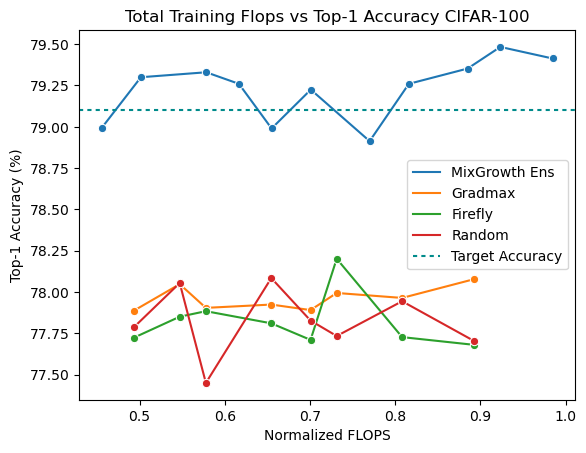

In [102]:
%matplotlib inline

g = sns.lineplot(data=df, x='FLOPS', y='acc',  
                 hue="color",marker="o")
g.axhline(target[1],dashes=[1.0,0.0,1.0],color='darkcyan', label='Target Accuracy')
g.legend()
plt
plt.title('Total Training Flops vs Top-1 Accuracy CIFAR-100')
plt.xlabel("Normalized FLOPS")
plt.ylabel("Top-1 Accuracy (%)")

plt.savefig('/projectnb/ivc-ml/piotrt/gradmax/growneuron/jupyter_analysis/ResultsFig.pdf')


In [87]:
grow_epoch, acc, flops = zip(*data)
dfours = pd.DataFrame(data={"grow_epoch": grow_epoch, "acc": acc, "FLOPS": np.array(flops)/target[-1]})
dfours["color"] = "MixGrowth Ens"

In [94]:
dfours_late_growth = dfours.iloc[-5:]

In [95]:
dfours_late_growth

,grow_epoch,acc,FLOPS,color
25,93,77.559998,0.309901,MixGrowth Ens
26,94,77.884285,0.302233,MixGrowth Ens
27,95,77.415001,0.294564,MixGrowth Ens
28,96,76.915001,0.286896,MixGrowth Ens
29,98,74.620003,0.271559,MixGrowth Ens


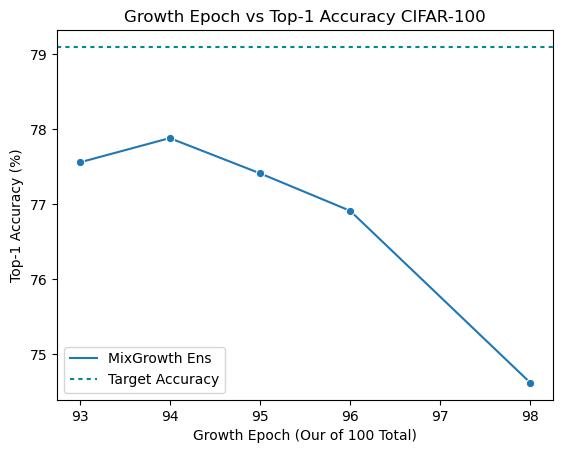

In [104]:
%matplotlib inline

g = sns.lineplot(data=dfours_late_growth, x='grow_epoch', y='acc',  
                 hue="color",marker="o")
g.axhline(target[1],dashes=[1.0,0.0,1.0],color='darkcyan', label='Target Accuracy')
g.legend()
plt
plt.title('Growth Epoch vs Top-1 Accuracy CIFAR-100')
plt.xlabel("Growth Epoch (Our of 100 Total)")
plt.ylabel("Top-1 Accuracy (%)")

plt.savefig("/projectnb/ivc-ml/piotrt/gradmax/growneuron/jupyter_analysis/LateGrowth.pdf")